In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
import time

# load preprocessed data

In [0]:
# load pre-processed data
# replace with local file-path if you're running on local python shell
train_X= pd.read_csv('/content/drive/My Drive/1003 project - Yelp fake review/train_X.csv')
train_y= pd.read_csv('/content/drive/My Drive/1003 project - Yelp fake review/train_y.csv')
val_X = pd.read_csv('/content/drive/My Drive/1003 project - Yelp fake review/val_X.csv')
val_y = pd.read_csv('/content/drive/My Drive/1003 project - Yelp fake review/val_y.csv')


In [115]:
train_users = train_X['user_id'].unique() # a list of all unique users in train
val_users = val_X['user_id'].unique() # a list of all unique users in val

len(list(set(train_users) & set(val_users))) # count of unique users in both sets

16027

In [25]:
train_X

,ex_id,user_id,prod_id,rating,date,review,cleaned review,text length,word length
0,0,923,0,3.0,2014-12-08,The food at snack is a selection of popular Gr...,b'the food snack select popular greek dish the...,215,40
1,1,924,0,3.0,2013-05-16,This little place in Soho is wonderful. I had ...,b'this littl place soho wonder lamb sandwich g...,269,52
2,2,925,0,4.0,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,b'order lunch snack last friday time noth miss...,178,32
3,3,926,0,4.0,2011-07-28,This is a beautiful quaint little restaurant o...,b'this beauti quaint littl restaur pretti stre...,491,90
4,4,927,0,4.0,2010-11-01,Snack is great place for a casual sit down lu...,b'snack great place casual sit especi cold win...,596,102
...,...,...,...,...,...,...,...,...,...
250869,358950,14671,349,5.0,2014-02-08,Made a reservation for an early dinner Saturda...,b'made reserv earli dinner saturday night luck...,1418,233
250870,358951,3356,349,5.0,2014-02-07,"Emily is like Franny's Marco, but with warmth ...",b'emili like franni marco warmth valu emili ch...,763,134
250871,358953,116424,349,5.0,2014-01-31,Can't say enough good things about this place....,b'cant say enough good thing place stop last n...,475,80
250872,358954,161147,349,5.0,2014-01-30,"Had a great dinner here- fantastic pizza, the ...",b'had great dinner fantast pizza smore pizza d...,268,51


Note that right now, the cleaned reviews are byte strings instead of normal strings, hence the `b' '` enclosing the string.


In [0]:
#add 2 new features: text length and word length. These are probably be useful
train_X['text length'] = train_X['review'].apply(len)
train_X['word length'] = train_X['review'].apply(lambda x: len(x.split(" "))) 

val_X['text length'] = val_X['review'].apply(len)
val_X['word length'] = val_X['review'].apply(lambda x: len(x.split(" ")))

# text length: the number of characters (including white spaces) in the string
# word length: the number of words in the string

In [11]:
train_X.head()

,ex_id,user_id,prod_id,rating,date,review,cleaned review,text length,word length
0,0,923,0,3.0,2014-12-08,The food at snack is a selection of popular Gr...,b'the food snack select popular greek dish the...,215,40
1,1,924,0,3.0,2013-05-16,This little place in Soho is wonderful. I had ...,b'this littl place soho wonder lamb sandwich g...,269,52
2,2,925,0,4.0,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,b'order lunch snack last friday time noth miss...,178,32
3,3,926,0,4.0,2011-07-28,This is a beautiful quaint little restaurant o...,b'this beauti quaint littl restaur pretti stre...,491,90
4,4,927,0,4.0,2010-11-01,Snack is great place for a casual sit down lu...,b'snack great place casual sit especi cold win...,596,102


In [12]:
val_X.shape

(35918, 9)

## create good and fake user sets

In [0]:
# piece the X and label together
train = pd.concat((train_X, train_y), axis=1)


In [0]:
# create a dictionary where 
  # the key is each unique user_id in the trianing set
  # the value is their average label score rounded to 3 digits
user_dict = round(train.groupby('user_id')['label'].mean(), 3).to_dict()


In [0]:
# an average label value of 1 means the user always leaves fake reviews, and gets added to the fake_user list
# an average label value of 0 means the user always leaves real revies, and gets added to the good_user list

fake_user=[]
good_user=[]

for k in user_dict.keys():
  if user_dict[k] == 1:
    fake_user.append(k)
  if user_dict[k] == 0:
    good_user.append(k)


In [0]:
# a list of row indices in the val set that corresponds to a review left by a fake user
fake_rows = val_X['user_id'][val_X['user_id'].isin(fake_user)].index.tolist()

# a list of row indices that corresponds to a review left by a good user
good_rows = val_X['user_id'][val_X['user_id'].isin(good_user)].index.tolist()


# resampling train set only

In [0]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

## ros upsample

In [0]:
# create a raondom sampler object from the class
ros = RandomOverSampler(random_state=0)

In [28]:
# create re-sampled data from the original data
# The augmented data set should be used instead of the original data set to train a classifier
train_X_ros, train_y_ros = ros.fit_sample(train_X, train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
# on local python shell, the trian_X_ros after oversampling is still DataFrame
# But on colab version it turned to array, so we need to change it back to a pd.df
train_X_ros = pd.DataFrame(train_X_ros, columns = ['ex_id','user_id','prod_id','rating','date','review','cleaned review','text length','word length'])
train_y_ros = pd.DataFrame(train_y_ros, columns = ['label'])

In [30]:
print('pre-upsampling genuine cases: ',train_y[train_y['label'] == 0].shape[0])
print('post-upsampling genuine cases: ',train_y_ros[train_y_ros['label'] == 0].shape[0])
print()
print('pre-upsampling fake cases: ',train_y[train_y['label'] == 1].shape[0])
print('post-upsampling fake cases: ',train_y_ros[train_y_ros['label'] == 1].shape[0])

pre-upsampling genuine cases:  225055
post-upsampling genuine cases:  225055

pre-upsampling fake cases:  25819
post-upsampling fake cases:  225055


now, the number of fake reviews is the same as the number of genuine reviews. We have fixed the class-imbalance issue.

## smote upsample

Random oversampling simply replicates randomly the minority class examples. Random oversampling is known to increase the likelihood of occurring overfitting. On the other hand, the major drawback of Random undersampling is that this method can discard useful data.

To avoid the over-fitting problem, Chawla et al. (2002) propose the Synthetic Minority Over-sampling Technique (SMOTE). This method is considered a state-of-art technique and works well in various applications. This method generates synthetic data based on the feature space similarities between existing minority instances. In order to create a synthetic instance, it finds the K-nearest neighbors of each minority instance, randomly selects one of them, and then calculate linear interpolations to produce a new minority instance in the neighborhood.

Since `SMOTE` only accepts floats for all features, we must convert to BoW representation first!. So go run the bag of words section then come back here.






In [0]:
# create a smote object
smo = SMOTE(random_state=0)

In [88]:
# create re-sampled data from the original data
# The augmented data set should be used instead of the original data set to train a classifier
BoW_train_X_smo, train_y_smo = smo.fit_sample(BoW_train_X_og, train_y)
# time: 243

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [89]:
type(BoW_train_X_smo)

scipy.sparse.csr.csr_matrix

In [90]:
BoW_train_X_smo.shape

(450110, 73944)

## adasyn upsample

ADASYN generates samples of the minority class according to their density distributions. More synthetic data is generated for minority class samples that are harder to learn

Since `ADASYN` only accepts floats for all features, we must convert to BoW representation first!. So go run the bag of words section then come back here.

In [0]:
# create a smote object
ada = ADASYN(random_state=0)

In [92]:
# create re-sampled data from the original data
# The augmented data set should be used instead of the original data set to train a classifier
BoW_train_X_ada, train_y_ada = ada.fit_sample(BoW_train_X_og, train_y)

# time: 590 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Text to vector conversion

## 3 extra feature columns for train and validation

In [0]:
# let's add the additional features to the training matrix
train_extra = np.array(train_X_ros[['text length','word length','rating']], dtype=float)

# normalize the extra features
train_extra_min = train_extra.min(axis = 0) # get the min value for each column
train_extra_max = train_extra.max(axis = 0) # get the max value for each column
train_extra = (train_extra - train_extra_min)/(train_extra_max-train_extra_min) # normalize each column to be between 0~1


In [0]:
# do the same for the validation X data

# let's add the additional features to the validation matrix
val_extra = np.array(val_X[['text length','word length','rating']], dtype=float)

# normalize the extra features
val_extra_min = val_extra.min(axis = 0) # get the min value for each column
val_extra_max = val_extra.max(axis = 0) # get the max value for each column
val_extra = (val_extra - val_extra_min)/(val_extra_max-val_extra_min) # normalize each column to be between 0~1



## bag of words

Bag of Words basically creates a dictionary of `d` words (this is not a python dictionary) where `d` is the number of unique words in our text corpus. It then creates `d` dimensional vectors (consider it an array of length `d`) for each document (review) in our corpus (total set of reviews) and each dimension (cell) has value equal to number of times the corresponding word has occurred in that particular document (review).

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
# create an object from class
# by default, CountVectorizer uses ’utf-8’ as the encoding to decode byte texts, which is the encoding used in our processed text
count_vect = CountVectorizer()

# learn (fit) the vocab dictionry and vetorize (transform) each review
BoW_train_X = count_vect.fit_transform(train_X_ros['cleaned review'])
# this returns a sparse matrix where each row represent a review
# this is no longer a dataframe!

In [19]:
BoW_train_X

<450110x73944 sparse matrix of type '<class 'numpy.int64'>'
	with 19957604 stored elements in Compressed Sparse Row format>

We can see that the matrix has the number of reviews as rows and 73944 unique words in all reviews

we also have to trasnform our validation set
but be careful, we cannot train the vectorizer on the validation set, because after training, our model only knows how to classify inputs that has the same # of features. So if we had fit our vectorizer on the validation set, it might result in a matrix with different numbers of features.

In [0]:
BoW_val_X = count_vect.transform(val_X['cleaned review'])

In [21]:
BoW_val_X

<35918x73944 sparse matrix of type '<class 'numpy.int64'>'
	with 1814781 stored elements in Compressed Sparse Row format>

Note how that although the number of rows changed (to equal to the same number of reviews in the validation set), the number of columns is the same as our training BoW set!

First, we can just use the BoW matrix, i.e., the unique-word features as our only features and start training the model. But later, we can also add in features such as rating, and text length to see if it betters our result! But if we add these other features, make sure to normalize them as they can be quite large numbers

In [0]:
# add these columns to our BoW matrix, remember to keep the sparse format
BoW_train_X_extra = sparse.hstack((BoW_train_X, train_extra))

In [33]:
train_extra.shape

(450110, 3)

In [0]:
# add these columns to our BoW matrix, remember to keep the sparse format
BoW_val_X_extra = sparse.hstack((BoW_val_X, val_extra))

In [35]:
val_extra.shape

(35918, 3)

### for smo and ada

In [0]:
# create an object from class
# by default, CountVectorizer uses ’utf-8’ as the encoding to decode byte texts, which is the encoding used in our processed text
count_vect = CountVectorizer()

# learn (fit) the vocab dictionry and vetorize (transform) each review
BoW_train_X_og = count_vect.fit_transform(train_X['cleaned review'])
# this returns a sparse matrix where each row represent a review
# this is no longer a dataframe!

In [80]:
BoW_train_X_og # this is used to upsample SMOTE and ADASYN

<250874x73944 sparse matrix of type '<class 'numpy.int64'>'
	with 12735728 stored elements in Compressed Sparse Row format>

In [0]:
BoW_val_X_og = count_vect.transform(val_X['cleaned review'])

In [82]:
BoW_val_X_og # this is used to validate SMOTE and ADASYN training data

<35918x73944 sparse matrix of type '<class 'numpy.int64'>'
	with 1814781 stored elements in Compressed Sparse Row format>

## TF-IDF

From the linear SVM implementation below, we can see that our `au_roc` score is very poor, almost the same as our Naive Bayes baseline model. We can guess that is because our word-vectors are not linearly separable in their 70000+ dimension space. Can we try to use TF-IDF and present them as vectors in a different way that makes the vectors more separable? This is why we want to try to use TF-IDF to represent our text. 

TF-IDF is an acronym than stands for “Term Frequency — Inverse Document” Frequency which are the components of the resulting scores assigned to each word. 

Term Frequency: This summarizes how often a given word appears within a document.

Inverse Document Frequency: This down scales words that appear a lot across documents.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
# create an object from class
# by default, TfidfVectorizer uses ’utf-8’ as the encoding to decode byte texts, which is the encoding used in our processed text
tfidf_vect = TfidfVectorizer()

In [0]:
# # learn (fit) the vocab dictionry from the entire data! not just the train!
# tfidf_vect.fit(pd.concat([train_X_ros['cleaned review'], val_X['cleaned review']]))

In [0]:
# learn (fit) the vocab dictionry and vetorize (transform) each review
tfidf_train_X = tfidf_vect.fit_transform(train_X_ros['cleaned review'])
# this returns a sparse matrix where each row represent a review
# this is no longer a dataframe!

In [40]:
tfidf_train_X

<450110x73944 sparse matrix of type '<class 'numpy.float64'>'
	with 19945603 stored elements in Compressed Sparse Row format>

We can see that the matrix has the number of reviews as rows and 73944 unique words in all reviews, same as our BoW of course.

we also have to trasnform our validation set but be careful, we cannot train the vectorizer on the validation set, because after training, our model only knows how to classify inputs that has the same # of features. So if we had fit our vectorizer on the validation set, it might result in a matrix with different numbers of features.

In [0]:
tfidf_val_X = tfidf_vect.transform(val_X['cleaned review'])

In [42]:
tfidf_val_X

<35918x73944 sparse matrix of type '<class 'numpy.float64'>'
	with 1814781 stored elements in Compressed Sparse Row format>

Similarly, add the 3 additioanl feature columns to the sparse matrix for both train and validation input.

In [43]:
# add these columns to our tfidf matrix, remember to keep the sparse format
tfidf_train_X_extra = sparse.hstack((tfidf_train_X, train_extra))
tfidf_train_X_extra

<450110x73947 sparse matrix of type '<class 'numpy.float64'>'
	with 21264581 stored elements in COOrdinate format>

In [44]:
# add these columns to our tfidf matrix, remember to keep the sparse format
tfidf_val_X_extra = sparse.hstack((tfidf_val_X, val_extra))
tfidf_val_X_extra

<35918x73947 sparse matrix of type '<class 'numpy.float64'>'
	with 1921031 stored elements in COOrdinate format>

## TF-IDF (1,2)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
# create an object from class
# by default, TfidfVectorizer uses ’utf-8’ as the encoding to decode byte texts, which is the encoding used in our processed text
# (1, 2) means unigrams and bigrams
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))

In [0]:
# # learn (fit) the vocab dictionry from the entire data! not just the train!
# tfidf_vect.fit(pd.concat([train_X_ros['cleaned review'], val_X['cleaned review']]))

In [0]:
# learn (fit) the vocab dictionry and vetorize (transform) each review
tfidf12_train_X = tfidf_vect.fit_transform(train_X_ros['cleaned review'])
# this returns a sparse matrix where each row represent a review
# this is no longer a dataframe!

In [43]:
tfidf12_train_X

<450110x3167368 sparse matrix of type '<class 'numpy.float64'>'
	with 42978102 stored elements in Compressed Sparse Row format>

We can see that the matrix has the number of reviews as rows and 73944 unique words in all reviews, same as our BoW of course.

we also have to trasnform our validation set but be careful, we cannot train the vectorizer on the validation set, because after training, our model only knows how to classify inputs that has the same # of features. So if we had fit our vectorizer on the validation set, it might result in a matrix with different numbers of features.

In [0]:
tfidf12_val_X = tfidf_vect.transform(val_X['cleaned review'])

In [45]:
tfidf12_val_X

<35918x3167368 sparse matrix of type '<class 'numpy.float64'>'
	with 3653739 stored elements in Compressed Sparse Row format>

Similarly, add the 3 additioanl feature columns to the sparse matrix for both train and validation input.

In [46]:
# add these columns to our tfidf matrix, remember to keep the sparse format
tfidf12_train_X_extra = sparse.hstack((tfidf12_train_X, train_extra))
tfidf12_train_X_extra

<450110x3167371 sparse matrix of type '<class 'numpy.float64'>'
	with 44297299 stored elements in COOrdinate format>

In [47]:
# add these columns to our tfidf matrix, remember to keep the sparse format
tfidf12_val_X_extra = sparse.hstack((tfidf12_val_X, val_extra))
tfidf12_val_X_extra

<35918x3167371 sparse matrix of type '<class 'numpy.float64'>'
	with 3759989 stored elements in COOrdinate format>

# Single linear model (SVM) training

In [0]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.kernel_approximation import Nystroem

In [47]:
# change the y-labels from dataframe to ndarray of shape (n_samples, ) for model inputs
train_y_ros_arr = np.array(train_y_ros['label'])
print(train_y_ros_arr.shape)

val_y_arr = np.array(val_y['label'])
print(val_y_arr.shape)

(450110,)
(35918,)


In [0]:
# create a function to print all the results in one place

def get_results(y_true, y_pred, y_score):
  '''
  Params:
  -------------------------------------
  y_true: ndarray of shape (n_samples, ) of true class labels \n
  y_pred: ndarray of shape (n_samples, ) of predicted class labels used for confusion matrix \n
  y_score: ndarray of shape (n_samples, ) of predicted confidence scores used for au_ROC and AP 
  '''

  print('au_roc score:', roc_auc_score(y_true, y_score))
  print('average precision score:', average_precision_score(y_true, y_score))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.title('ROC')

  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  curve = plt.plot(fpr, tpr, label = 'SVM' + ' (AUC = %0.3f)' % roc_auc_score(y_true, y_score))
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  plt.show()

  print()
  print('Confusion Matrix:')
  print(pd.DataFrame(confusion_matrix(y_true, y_pred), index=['actual negative', 'actual positive'], 
             columns=['predicted negative', 'predicted positive']))
  
  return

## linear SVM with BoW_smo data

In [0]:
# create the svc model object
svclassifier = SVC(kernel='linear')

In [0]:
# fit the model to our training data
# !!! do not start running this if you're not prepared to wait for 3 hours
svclassifier.fit(BoW_train_X_smo, np.array(train_y_smo['label'])

As stated by the API, `svc` does not handle large datasets (> 10,000 instances) well, and this fit took forever! For large datasets consider using `sklearn.svm.LinearSVC` or `sklearn.linear_model.SGDClassifier` instead. However, those are all linear kernel models and does not offer me the option of choosing kernels such as `sigmoid` or `poly`. Any work around?

Look into [`sklearn.kernel_approximation.Nystroem`](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.Nystroem.html#sklearn.kernel_approximation.Nystroem)

In [0]:
# create SGDclassifier object
sgd = SGDClassifier(random_state=2)

In [116]:
# fit the model to our training data
sgd.fit(BoW_train_X_smo, np.array(train_y_smo))

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=2, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
# predict the labels for our validation set
val_pred = sgd.predict(BoW_val_X_og)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
val_score = sgd.decision_function(BoW_val_X_og)
# this returns a ndarray of shape (n_samples, )

In [118]:
val_pred.shape

(35918,)

au_roc score: 0.6778036256245277
average precision score: 0.1865670228826518


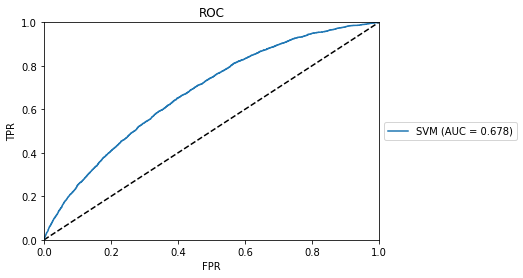


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               27502                4768
actual positive                2452                1196


In [119]:
get_results(val_y_arr, val_pred, val_score)

## linear SVM with BoW_ada data

In [0]:
# create the svc model object
svclassifier = SVC(kernel='linear')

In [0]:
# fit the model to our training data
# !!! do not start running this if you're not prepared to wait for 3 hours
svclassifier.fit(BoW_train_X_smo, np.array(train_y_smo['label'])

As stated by the API, `svc` does not handle large datasets (> 10,000 instances) well, and this fit took forever! For large datasets consider using `sklearn.svm.LinearSVC` or `sklearn.linear_model.SGDClassifier` instead. However, those are all linear kernel models and does not offer me the option of choosing kernels such as `sigmoid` or `poly`. Any work around?

Look into [`sklearn.kernel_approximation.Nystroem`](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.Nystroem.html#sklearn.kernel_approximation.Nystroem)

In [0]:
# create SGDclassifier object
sgd = SGDClassifier(random_state=2)

In [121]:
# fit the model to our training data
sgd.fit(BoW_train_X_ada, np.array(train_y_ada))

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=2, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
# predict the labels for our validation set
val_pred = sgd.predict(BoW_val_X_og)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
val_score = sgd.decision_function(BoW_val_X_og)
# this returns a ndarray of shape (n_samples, )

In [123]:
val_pred.shape

(35918,)

au_roc score: 0.6743473167395169
average precision score: 0.18691222556159032


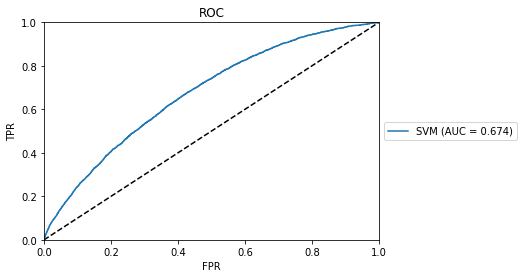


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               27902                4368
actual positive                2551                1097


In [124]:
get_results(val_y_arr, val_pred, val_score)

## linear SVM with BoW data

In [0]:
# create the svc model object
svclassifier = SVC(kernel='linear')

In [0]:
# fit the model to our training data
# !!! do not start running this if you're not prepared to wait for 3 hours
svclassifier.fit(BoW_train_X, train_y_ros)

As stated by the API, `svc` does not handle large datasets (> 10,000 instances) well, and this fit took forever! For large datasets consider using `sklearn.svm.LinearSVC` or `sklearn.linear_model.SGDClassifier` instead. However, those are all linear kernel models and does not offer me the option of choosing kernels such as `sigmoid` or `poly`. Any work around?

Look into [`sklearn.kernel_approximation.Nystroem`](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.Nystroem.html#sklearn.kernel_approximation.Nystroem)

In [0]:
# create SGDclassifier object
sgd = SGDClassifier(random_state=2)

In [166]:
# fit the model to our training data
sgd.fit(BoW_train_X, train_y_ros_arr)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=2, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
# predict the labels for our validation set
val_pred = sgd.predict(BoW_val_X)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
val_score = sgd.decision_function(BoW_val_X)
# this returns a ndarray of shape (n_samples, )

In [168]:
val_pred.shape

(35918,)

au_roc score: 0.7106028781960323
average precision score: 0.1954755480517305


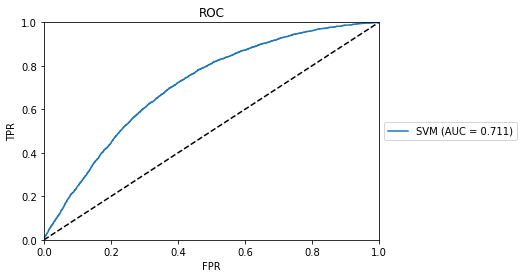


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               17324               14946
actual positive                 792                2856


In [169]:
get_results(val_y_arr, val_pred, val_score)

In [170]:
pd.DataFrame(confusion_matrix(val_y_arr, val_pred), index=['actual negative', 'actual positive'], 
             columns=['predicted negative', 'predicted positive'])

,predicted negative,predicted positive
actual negative,17324,14946
actual positive,792,2856


## linear SVM BoW_extra data

In [0]:
# create SGDclassifier object
sgd = SGDClassifier(random_state=2)

In [172]:
# fit the model to our training data with extra features
sgd.fit(BoW_train_X_extra, train_y_ros_arr)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=2, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
# predict the labels for our validation set
val_pred = sgd.predict(BoW_val_X_extra)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
val_score = sgd.decision_function(BoW_val_X_extra)
# this returns a ndarray of shape (n_samples, )

au_roc score: 0.7126695067726257
average precision score: 0.19843380359394686


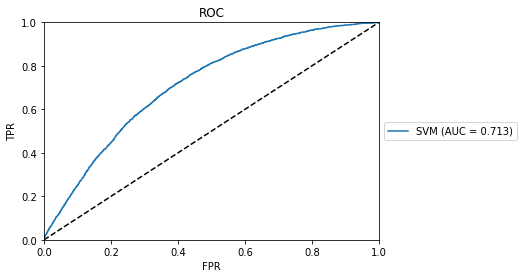


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               17482               14788
actual positive                 818                2830


In [174]:
get_results(val_y_arr, val_pred, val_score)

Well, both metrics are a tiny bit better. So we will use the matrix that inludes these extra features from now on.

In [154]:
pd.DataFrame(confusion_matrix(val_y_arr, val_pred), index=['actual negative', 'actual positive'], 
             columns=['predicted negative', 'predicted positive'])

,predicted negative,predicted positive
actual negative,18549,13721
actual positive,921,2727


## linear SVM with tfidf_extra data

In [0]:
# create SGDclassifier object
sgd = SGDClassifier(random_state=1)

In [156]:
# fit the model to our training data
sgd.fit(tfidf_train_X_extra, train_y_ros_arr)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
# predict the labels for our validation set
val_pred = sgd.predict(tfidf_val_X_extra)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
val_score = sgd.decision_function(tfidf_val_X_extra)
# this returns a ndarray of shape (n_samples, )

In [158]:
val_pred.shape

(35918,)

au_roc score: 0.7270731057578871
average precision score: 0.21705176643914137


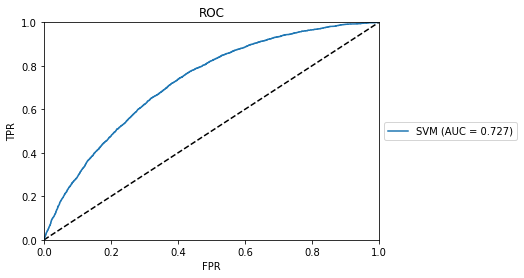


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               19179               13091
actual positive                 932                2716


In [159]:
get_results(val_y_arr, val_pred, val_score)

The `tfidf_extra` data performs better than BoW on the baseline `sgd` model.

## linear SVM with tfidf12_extra data

In [0]:
# create SGDclassifier object 
# let's try the params from the linear BoW search
sgd = SGDClassifier(random_state=1)

In [161]:
# fit the model to our training data
sgd.fit(tfidf12_train_X_extra, train_y_ros_arr)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
# predict the labels for our validation set
val_pred = sgd.predict(tfidf12_val_X_extra)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
val_score = sgd.decision_function(tfidf12_val_X_extra)
# this returns a ndarray of shape (n_samples, )

In [163]:
val_pred.shape

(35918,)

au_roc score: 0.7182314347419524
average precision score: 0.21454794277351705


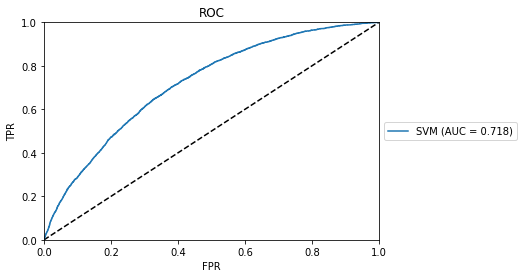


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               14911               17359
actual positive                 600                3048


In [164]:
get_results(val_y_arr, val_pred, val_score)

From this single implementation, it seems like that TF-IDF with `ngram_range = (1,2)` does even **worse** than unigram. This means that the only options we have left to try are possible different kernels. Trying the best linear BoW params is even worse...

So, we will just be using `tfidf_extra` data, which uses unigram, from now on.

# Single model training with kernelized TF-IDF_extra data

[some basics about the kernel trick](https://towardsdatascience.com/the-kernel-trick-c98cdbcaeb3f)

Kernel feature functions perform non-linear transformations of the input vectors to 'transform' them into linearly separable data, which can serve as a basis for linear classification or other algorithms.



Since there has not been much empirical work using approximate embeddings, it is advisable to compare results against exact kernel methods when possible. However, since it will take about 55 hours to train an exact kernelized `svc` on our training data, we won't be able to compare results.

The Nystroem method, as implemented in `Nystroem` is a general method for low-rank approximations of kernels. It achieves this by essentially **subsampling** the data on which the kernel is evaluated. By default `Nystroem` uses the `rbf` kernel, but it can use any kernel function or a precomputed kernel matrix. The number of samples used - which is also the dimensionality of the features computed - is given by the parameter `n_components`.

## rbf kernel approx

In [0]:
# initialize kernel object for use 
rbf_kernel = Nystroem(kernel = 'rbf',
                      random_state=1,
                      gamma = 1,
                      n_components=400)

In [79]:
# kernel transform our input data, so for both train and validation
start = time.time()
tfidf_train_X_extra_rbf = rbf_kernel.fit_transform(tfidf_train_X_extra, train_y_ros_arr)
tfidf_val_X_extra_rbf = rbf_kernel.transform(tfidf_val_X_extra)
print('time:', time.time()-start)

time: 24.519733667373657


In [80]:
tfidf_train_X_extra_rbf.shape

(450110, 400)

In [81]:
# create SGDclassifier object
sgd = SGDClassifier()

# fit the model to our training data
sgd.fit(tfidf_train_X_extra_rbf, train_y_ros_arr)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
# predict the labels for our validation set
val_pred = sgd.predict(tfidf_val_X_extra_rbf)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
val_score = sgd.decision_function(tfidf_val_X_extra_rbf)
# this returns a ndarray of shape (n_samples, )

In [83]:
val_pred.shape

(35918,)

au_roc score: 0.6938936022947826
average precision score: 0.19457398925103314


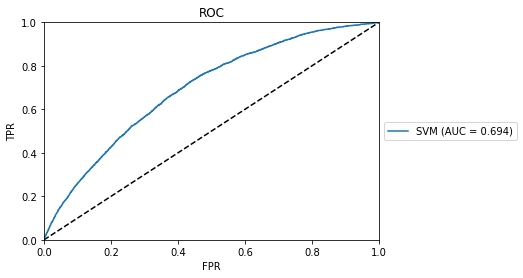


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               15852               16418
actual positive                 788                2860


In [84]:
get_results(val_y_arr, val_pred, val_score)

## sigmoid kernel approx

In [0]:
# initialize kernel object for use 
sigmoid_kernel = Nystroem(kernel='sigmoid',
                          gamma=1,
                          random_state=1,
                          n_components=401)

In [86]:
# kernel transform our input data, so for both train and validation
start = time.time()
tfidf_train_X_extra_sig = sigmoid_kernel.fit_transform(tfidf_train_X_extra)
tfidf_val_X_extra_sig = sigmoid_kernel.transform(tfidf_val_X_extra)
print(time.time() - start)

25.240594625473022


In [87]:
tfidf_train_X_extra_sig.shape

(450110, 401)

In [88]:
# create SGDclassifier object
sgd = SGDClassifier()

# fit the model to our training data
sgd.fit(tfidf_train_X_extra_sig, train_y_ros_arr)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
# predict the labels for our validation set
val_pred = sgd.predict(tfidf_val_X_extra_sig)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
val_score = sgd.decision_function(tfidf_val_X_extra_sig)
# this returns a ndarray of shape (n_samples, )

In [90]:
val_pred.shape

(35918,)

au_roc score: 0.6961842436555054
average precision score: 0.19953884563685126


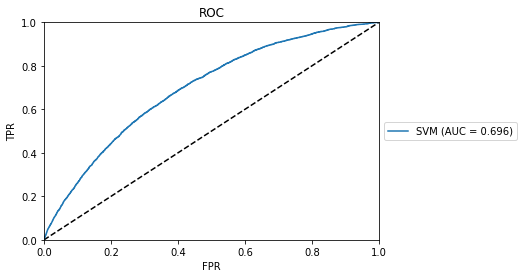


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               11618               20652
actual positive                 449                3199


In [91]:
get_results(val_y_arr, val_pred, val_score)

## poly kernel approx

In [0]:
# initialize kernel object for use 
poly_kernel = Nystroem(kernel='poly',
                       gamma=1,
                       degree = 3,
                       random_state=1,
                       n_components=402)

In [93]:
# kernel transform our input data, so for both train and validation
start = time.time()
tfidf_train_X_extra_poly = poly_kernel.fit_transform(tfidf_train_X_extra)
tfidf_val_X_extra_poly = poly_kernel.transform(tfidf_val_X_extra)
print(time.time()-start)

32.45128870010376


In [94]:
tfidf_train_X_extra_poly.shape

(450110, 402)

In [95]:
# create SGDclassifier object
sgd = SGDClassifier()

# fit the model to our training data
sgd.fit(tfidf_train_X_extra_poly, train_y_ros_arr)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
# predict the labels for our validation set
val_pred = sgd.predict(tfidf_val_X_extra_poly)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
val_score = sgd.decision_function(tfidf_val_X_extra_poly)
# this returns a ndarray of shape (n_samples, )

In [97]:
val_pred.shape

(35918,)

au_roc score: 0.7121439673954408
average precision score: 0.2015389000632624


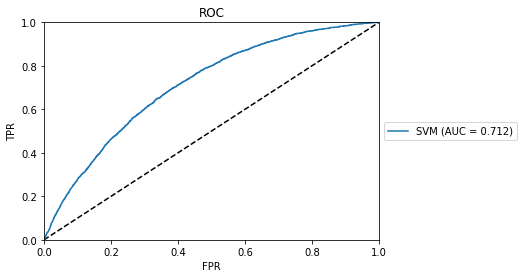


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               18909               13361
actual positive                1001                2647


In [98]:
get_results(val_y_arr, val_pred, val_score)

## additive_chi2 kernel approx 

`additive_chi2` does not support sparse matrices. But just converting the smaller validation data from sparse back to dense array representation crashed my session and exceeded all of my available RAM. Put a pin in it for now.

In [0]:
# initialize kernel object for use 
adc2_kernel = Nystroem(kernel = 'additive_chi2',
                       random_state=1,
                       gamma = 1,
                       n_components=530)

In [53]:
# kernel transform our input data, so for both train and validation
tfidf_train_X_extra_adc2 = adc2_kernel.fit_transform(tfidf_train_X_extra)
tfidf_val_X_extra_adc2 = adc2_kernel.transform(tfidf_val_X_extra)

ValueError: ignored

In [0]:
tfidf_train_X_extra_adc2.shape

In [0]:
# create SGDclassifier object
sgd = SGDClassifier()

# fit the model to our training data
sgd.fit(tfidf_train_X_extra_adc2, train_y_ros_arr)

In [0]:
# predict the labels for our validation set
val_pred = sgd.predict(tfidf_val_X_extra_adc2)
# this returns a ndarray of shape (n_samples, )

In [0]:
val_pred.shape

In [0]:
get_results(val_y_arr, val_pred)

## chi2 kernel approx 

`chi2` does not support sparse matrices. But just converting the smaller validation data from sparse back to dense array representation crashed my session and exceeded all of my available RAM. Put a pin in it for now.

In [0]:
# initialize kernel object for use 
c2_kernel = Nystroem(kernel = 'chi2',
                     random_state=1,
                     gamma = 1,
                     n_components=540)

In [42]:
# kernel transform our input data, so for both train and validation
tfidf_train_X_extra_c2 = c2_kernel.fit_transform(tfidf_train_X_extra)
tfidf_val_X_extra_c2 = c2_kernel.transform(tfidf_val_X_extra)

ValueError: ignored

In [0]:
tfidf_train_X_extra_c2.shape

In [0]:
# create SGDclassifier object
sgd = SGDClassifier()

# fit the model to our training data
sgd.fit(tfidf_train_X_extra_c2, train_y_ros_arr)

In [0]:
# predict the labels for our validation set
val_pred = sgd.predict(tfidf_val_X_extra_c2)
# this returns a ndarray of shape (n_samples, )

In [0]:
val_pred.shape

In [0]:
get_results(val_y_arr, val_pred)

## laplacian kernel approx 

In [0]:
# initialize kernel object for use 
lap_kernel = Nystroem(kernel = 'laplacian',
                       random_state=1,
                       gamma = 1,
                       n_components=403)

In [100]:
# kernel transform our input data, so for both train and validation
start = time.time()
tfidf_train_X_extra_lap = lap_kernel.fit_transform(tfidf_train_X_extra)
tfidf_val_X_extra_lap = lap_kernel.transform(tfidf_val_X_extra)
print(time.time()-start)

118.1267728805542


In [101]:
tfidf_train_X_extra_lap.shape

(450110, 403)

In [102]:
# create SGDclassifier object
sgd = SGDClassifier()

# fit the model to our training data
sgd.fit(tfidf_train_X_extra_lap, train_y_ros_arr)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
# predict the labels for our validation set
val_pred = sgd.predict(tfidf_val_X_extra_lap)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
val_score = sgd.decision_function(tfidf_val_X_extra_lap)
# this returns a ndarray of shape (n_samples, )

In [104]:
val_pred.shape

(35918,)

au_roc score: 0.6325375277265833
average precision score: 0.16679894181716304


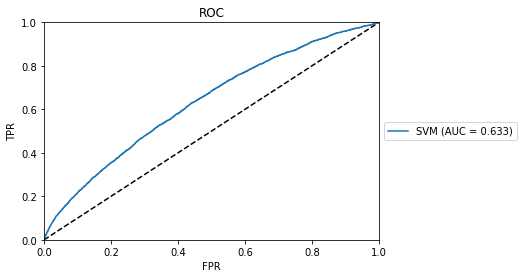


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               31051                1219
actual positive                3241                 407


In [105]:
get_results(val_y_arr, val_pred, val_score)

## cosine kernel approx 

In [0]:
# initialize kernel object for use 
cos_kernel = Nystroem(kernel = 'cosine',
                       random_state=1,
                       gamma = 1,
                       n_components=404)

In [43]:
# kernel transform our input data, so for both train and validation
start=time.time()
tfidf_train_X_extra_cos = cos_kernel.fit_transform(tfidf_train_X_extra)
tfidf_val_X_extra_cos = cos_kernel.transform(tfidf_val_X_extra)
print(time.time()-start)

18.319141626358032


In [44]:
tfidf_train_X_extra_cos.shape

(450110, 404)

In [45]:
# create SGDclassifier object
sgd = SGDClassifier()

# fit the model to our training data
sgd.fit(tfidf_train_X_extra_cos, train_y_ros_arr)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
# predict the labels for our validation set
val_pred = sgd.predict(tfidf_val_X_extra_cos)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
val_score = sgd.decision_function(tfidf_val_X_extra_cos)
# this returns a ndarray of shape (n_samples, )

In [47]:
val_pred.shape

(35918,)

au_roc score: 0.7055780126155953
average precision score: 0.2070720019790555


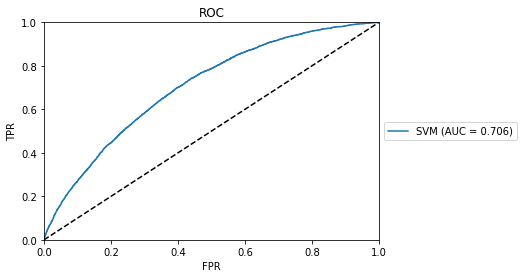


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               15118               17152
actual positive                 682                2966


In [49]:
get_results(val_y_arr, val_pred, val_score)

# GPU check

In [67]:
!ps -aux|grep python

root          18  0.2  0.7 412244 102480 ?       Sl   10:34   0:09 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --MappingKernelManager.root_dir="/content"
root         120 69.7 40.4 6149556 5391232 ?     Ssl  10:44  30:08 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-a440e38d-010b-4265-8ac4-3af8bf50330c.json
root         927  0.0  0.0  39196  6580 ?        S    11:27   0:00 /bin/bash -c ps -aux|grep python
root         929  0.0  0.0  38568  5560 ?        S    11:27   0:00 grep python


In [0]:
!kill -9 id_1

# Grid Search for kernel params

In [0]:
from sklearn.model_selection import GridSearchCV

## rbf, laplacian, cosine

In [0]:
def best_kernel(dict_params, tfidf_train_X_extra, tfidf_val_X_extra, train_y_ros_arr, val_y_arr):
  '''
  Params:
  -------------------------------------
  dict_params: a dictionary of parameters, should have the following keys
    'kernel': a list of strings where each string is a kernel function name
    'n_components': a list of ints, Number of features to construct
    'gamma': a list of floats, Gamma parameter used only for the RBF, laplacian, polynomial, exponential chi2 and sigmoid kernels.

  Return:
  -------
  best_params: a dictionary of the best performing parameters for kernelization
  '''

  best_auc = 0
  best_params = dict()

  for kernel_ in dict_params['kernel']:
    for n_ in dict_params['n_components']:
      for gamma_ in dict_params['gamma']:
        # initialize kernel object for use 
        kernel_func = Nystroem(kernel = kernel_,
                               n_components=n_,
                               gamma = gamma_,
                               random_state = 1)
        
        # kernel transform our input data, so for both train and validation
        tfidf_train_X_extra_ker = kernel_func.fit_transform(tfidf_train_X_extra)
        tfidf_val_X_extra_ker = kernel_func.transform(tfidf_val_X_extra)

        # create SGDclassifier object
        sgd = SGDClassifier()

        # fit the model to our training data
        sgd.fit(tfidf_train_X_extra_ker, train_y_ros_arr)

        # predict the decision for our validation set
        val_score = sgd.decision_function(tfidf_val_X_extra_ker)
        # this returns a ndarray of shape (n_samples, )

        auc = roc_auc_score(val_y_arr, val_score)

        if auc > best_auc: # update best params when we get a better / larger auc
          best_params['kernel']=kernel_
          best_params['n_components']=n_
          best_params['gamma']=gamma_
          best_params['auc']=auc
          print('new best auc score:', auc)
          print(best_params)
          print()
          best_auc = auc # update auc as the new best auc


  return best_params

In [0]:
dict_params={'kernel':['rbf', 'laplacian', 'cosine'],
             'n_components':[100, 300, 600],
             'gamma':[10**i for i in range(-2,2)]}

In [71]:
start = time.time()
best_params = best_kernel(dict_params, tfidf_train_X_extra, tfidf_val_X_extra, train_y_ros_arr, val_y_arr)
print(time.time()-start)
# time: 1860 secs

new best auc score: 0.6107590695828508
{'kernel': 'rbf', 'n_components': 100, 'gamma': 0.01, 'auc': 0.6107590695828508}

new best auc score: 0.6857482049076052
{'kernel': 'rbf', 'n_components': 100, 'gamma': 0.1, 'auc': 0.6857482049076052}

new best auc score: 0.7025010414458054
{'kernel': 'rbf', 'n_components': 300, 'gamma': 0.1, 'auc': 0.7025010414458054}

new best auc score: 0.7092696321878448
{'kernel': 'rbf', 'n_components': 600, 'gamma': 0.1, 'auc': 0.7092696321878448}

new best auc score: 0.7115395083424396
{'kernel': 'laplacian', 'n_components': 600, 'gamma': 0.1, 'auc': 0.7115395083424396}

1860.2003331184387


In [72]:
best_params

{'auc': 0.7115395083424396,
 'gamma': 0.1,
 'kernel': 'laplacian',
 'n_components': 600}

## poly

In [0]:
def best_kernel2(dict_params, tfidf_train_X_extra, tfidf_val_X_extra, train_y_ros_arr, val_y_arr):
  '''
  Params:
  -------------------------------------
  dict_params: a dictionary of parameters, should have the following keys
    'kernel': a list of strings where each string is a kernel function name
    'n_components': a list of ints, Number of features to construct
    'gamma': a list of floats, Gamma parameter used only for the RBF, laplacian, polynomial, exponential chi2 and sigmoid kernels.
    'coef0': a list of floats, Zero coefficient used only for polynomial and sigmoid kernels.
    'degree': a list of floats, Degree of the polynomial kernel used only for the polynomial kernel

  Return:
  --------------------------------------
  best_params: a dictionary of the best performing parameters for kernelization
  '''

  best_auc = 0
  best_params = dict()

  for kernel_ in dict_params['kernel']:
    for n_ in dict_params['n_components']:
      for gamma_ in dict_params['gamma']:
        for coef0_ in dict_params['coef0']:
          for degree_ in dict_params['degree']:
        
            # initialize kernel object for use 
            kernel_func = Nystroem(kernel = kernel_,
                                  n_components=n_,
                                  gamma = gamma_,
                                   coef0=coef0_,
                                   degree=degree_,
                                  random_state = 1)
            
            # kernel transform our input data, so for both train and validation
            tfidf_train_X_extra_ker = kernel_func.fit_transform(tfidf_train_X_extra)
            tfidf_val_X_extra_ker = kernel_func.transform(tfidf_val_X_extra)

            # create SGDclassifier object
            sgd = SGDClassifier()

            # fit the model to our training data
            sgd.fit(tfidf_train_X_extra_ker, train_y_ros_arr)

            # predict the decision for our validation set
            val_score = sgd.decision_function(tfidf_val_X_extra_ker)
            # this returns a ndarray of shape (n_samples, )

            auc = roc_auc_score(val_y_arr, val_score)

            if auc > best_auc: # update best params when we get a better / larger auc
              best_params['kernel']=kernel_
              best_params['n_components']=n_
              best_params['gamma']=gamma_
              best_params['coef0']=coef0_
              best_params['degree']=degree_
              best_params['auc'] = auc
              print('new best auc score:', auc)
              print(best_params)
              print()
              best_auc = auc


  return best_params

In [0]:
dict_params2={'kernel':['poly'],
             'n_components':[300, 600],
             'gamma':[10**i for i in range(-2,2)],
             'coef0':[10**i for i in range(-1,3)],
             'degree':[i for i in range(1,4)]}

In [54]:
start = time.time()
best_params2 = best_kernel2(dict_params2, tfidf_train_X_extra, tfidf_val_X_extra, train_y_ros_arr, val_y_arr)
print(time.time()-start)
# time: 12258 secs = 3.5 hrs

new best auc score: 0.6234861616826775
{'kernel': 'poly', 'n_components': 300, 'gamma': 0.01, 'coef0': 0.1, 'degree': 1, 'auc': 0.6234861616826775}

new best auc score: 0.6266680759314229
{'kernel': 'poly', 'n_components': 300, 'gamma': 0.01, 'coef0': 1, 'degree': 1, 'auc': 0.6266680759314229}

new best auc score: 0.6550588569784004
{'kernel': 'poly', 'n_components': 300, 'gamma': 0.01, 'coef0': 1, 'degree': 2, 'auc': 0.6550588569784004}

new best auc score: 0.6700309571039855
{'kernel': 'poly', 'n_components': 300, 'gamma': 0.01, 'coef0': 1, 'degree': 3, 'auc': 0.6700309571039855}

new best auc score: 0.6947334314976704
{'kernel': 'poly', 'n_components': 300, 'gamma': 0.01, 'coef0': 10, 'degree': 2, 'auc': 0.6947334314976704}

new best auc score: 0.7015816427253057
{'kernel': 'poly', 'n_components': 300, 'gamma': 0.01, 'coef0': 10, 'degree': 3, 'auc': 0.7015816427253057}

new best auc score: 0.7027325847495637
{'kernel': 'poly', 'n_components': 300, 'gamma': 0.1, 'coef0': 1, 'degree':

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


new best auc score: 0.7114600450081277
{'kernel': 'poly', 'n_components': 600, 'gamma': 0.01, 'coef0': 10, 'degree': 3, 'auc': 0.7114600450081277}

new best auc score: 0.7115708069319178
{'kernel': 'poly', 'n_components': 600, 'gamma': 0.1, 'coef0': 10, 'degree': 2, 'auc': 0.7115708069319178}

new best auc score: 0.7142315140821142
{'kernel': 'poly', 'n_components': 600, 'gamma': 1, 'coef0': 0.1, 'degree': 2, 'auc': 0.7142315140821142}

new best auc score: 0.7176280290272862
{'kernel': 'poly', 'n_components': 600, 'gamma': 1, 'coef0': 1, 'degree': 2, 'auc': 0.7176280290272862}



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


12258.018736124039


In [55]:
best_params2

{'auc': 0.7176280290272862,
 'coef0': 1,
 'degree': 2,
 'gamma': 1,
 'kernel': 'poly',
 'n_components': 600}

## sigmoid

In [0]:
def best_kernel3(dict_params, tfidf_train_X_extra, tfidf_val_X_extra, train_y_ros_arr, val_y_arr):
  '''
  Params:
  -------------------------------------
  dict_params: a dictionary of parameters, should have the following keys
    'kernel': a list of strings where each string is a kernel function name
    'n_components': a list of ints, Number of features to construct
    'gamma': a list of floats, Gamma parameter used only for the RBF, laplacian, polynomial, and sigmoid kernels.
    'coef0': a list of floats, Zero coefficient used only for polynomial and sigmoid kernels.

  Return:
  --------------------------------------
  best_params: a dictionary of the best performing parameters for kernelization
  '''

  best_auc = 0
  best_params = dict()

  for kernel_ in dict_params['kernel']:
    for n_ in dict_params['n_components']:
      for gamma_ in dict_params['gamma']:
        for coef0_ in dict_params['coef0']:
        
          # initialize kernel object for use 
          kernel_func = Nystroem(kernel = kernel_,
                                n_components=n_,
                                gamma = gamma_,
                                  coef0=coef0_,
                                random_state = 1)
          
          # kernel transform our input data, so for both train and validation
          tfidf_train_X_extra_ker = kernel_func.fit_transform(tfidf_train_X_extra)
          tfidf_val_X_extra_ker = kernel_func.transform(tfidf_val_X_extra)

          # create SGDclassifier object
          sgd = SGDClassifier()

          # fit the model to our training data
          sgd.fit(tfidf_train_X_extra_ker, train_y_ros_arr)

          # predict the decision for our validation set
          val_score = sgd.decision_function(tfidf_val_X_extra_ker)
          # this returns a ndarray of shape (n_samples, )

          auc = roc_auc_score(val_y_arr, val_score)

          if auc > best_auc: # update best params when we get a better / larger auc
            best_params['kernel']=kernel_
            best_params['n_components']=n_
            best_params['gamma']=gamma_
            best_params['coef0']=coef0_
            best_params['auc'] = auc
            print('new best auc score:', auc)
            print(best_params)
            print()
            best_auc = auc


  return best_params

In [0]:
dict_params3={'kernel':['sigmoid'],
             'n_components':[100, 300, 600],
             'gamma':[10**i for i in range(-2,2)],
             'coef0':[10**i for i in range(-1,3)]}

In [58]:
start = time.time()
best_params3 = best_kernel3(dict_params3, tfidf_train_X_extra, tfidf_val_X_extra, train_y_ros_arr, val_y_arr)
print(time.time()-start)
# time: 2885 secs = 48 sec

new best auc score: 0.5904080080556597
{'kernel': 'sigmoid', 'n_components': 100, 'gamma': 0.01, 'coef0': 0.1, 'auc': 0.5904080080556597}

new best auc score: 0.5908570274996059
{'kernel': 'sigmoid', 'n_components': 100, 'gamma': 0.01, 'coef0': 1, 'auc': 0.5908570274996059}

new best auc score: 0.6634090097464377
{'kernel': 'sigmoid', 'n_components': 100, 'gamma': 0.1, 'coef0': 0.1, 'auc': 0.6634090097464377}

new best auc score: 0.6766511290767592
{'kernel': 'sigmoid', 'n_components': 100, 'gamma': 1, 'coef0': 0.1, 'auc': 0.6766511290767592}

new best auc score: 0.6875851207805305
{'kernel': 'sigmoid', 'n_components': 300, 'gamma': 0.1, 'coef0': 0.1, 'auc': 0.6875851207805305}

new best auc score: 0.7015109416369012
{'kernel': 'sigmoid', 'n_components': 300, 'gamma': 1, 'coef0': 0.1, 'auc': 0.7015109416369012}

new best auc score: 0.7074690055194929
{'kernel': 'sigmoid', 'n_components': 600, 'gamma': 1, 'coef0': 0.1, 'auc': 0.7074690055194929}

2885.729292869568


In [59]:
best_params3

{'auc': 0.7074690055194929,
 'coef0': 0.1,
 'gamma': 1,
 'kernel': 'sigmoid',
 'n_components': 600}

# Grid Search for SGD params

In [0]:
from sklearn.model_selection import GridSearchCV

## linear SVM with BoW_extra data - early stopping - AP

In [57]:
# create SGDclassifier object
sgd = SGDClassifier()

# create a dict where keys are param names and values are a list of values to try for that param
grid_values = {'loss':['hinge', 'log'], 
               'penalty':['l2', 'l1', 'elasticnet'],
               'alpha':[10**(-i) for i in range(6)],
               'tol':[10**(-i) for i in range(2,5)],
               'early_stopping':[True]
               }

# create gridSearch object specifying model, params to search over, the scoring metric
grid_sgd = GridSearchCV(sgd, param_grid = grid_values, scoring = 'average_precision')

# fit on data
start = time.time()
grid_sgd.fit(BoW_train_X_extra, train_y_ros_arr)
print(time.time()-start)

# time: 1569

1569.418023109436


In [58]:
grid_sgd.best_params_

{'alpha': 0.01,
 'early_stopping': True,
 'loss': 'log',
 'penalty': 'l2',
 'tol': 0.01}

### in-sample score

In [59]:
# Mean cross-validated score of the best_estimator
grid_sgd.best_score_

0.653446128540424

In [61]:
# this is the same as the following
# which proves that grid score does use y_score to calculate and return auROC score
# and that it does use this correct auROC score to select the best model
print('this is the trianing AUC! not the validation:',grid_sgd.score(BoW_train_X_extra, train_y_ros_arr))

this is the trianing AUC! not the validation: 0.6944337256655556


au_roc score: 0.7277828933006925
average precision score: 0.6944337256655556


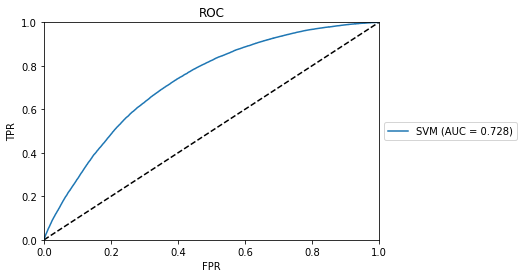


Confusion Matrix:
                 predicted negative  predicted positive
actual negative              134489               90566
actual positive               57662              167393


In [63]:
# evalute the best model on the actual validation set
train_pred = grid_sgd.predict(BoW_train_X_extra)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
train_score = grid_sgd.decision_function(BoW_train_X_extra)
# this returns a ndarray of shape (n_samples, )

get_results(train_y_ros_arr, train_pred, train_score)

### out-of-sample validation score

In [64]:
grid_sgd.score(BoW_val_X_extra, val_y_arr)

0.2047170132661991

In [0]:
# evalute the best model on the actual validation set
val_pred = grid_sgd.predict(BoW_val_X_extra)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
val_score = grid_sgd.decision_function(BoW_val_X_extra)
# this returns a ndarray of shape (n_samples, )

au_roc score: 0.7173404379305097
average precision score: 0.2047170132661991


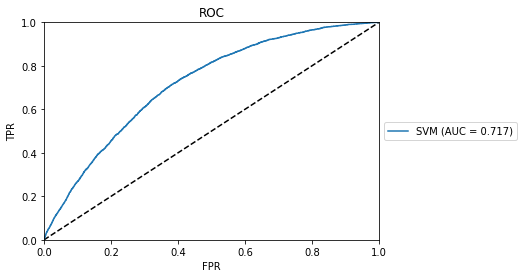


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               19200               13070
actual positive                 963                2685


In [0]:
get_results(val_y_arr, val_pred, val_score)

Notice that no matter if you chose `roc_auc` or `average_precision` as your scorer, their optimal value yeild the same model.

## linear SVM with BoW_extra data - early stopping

In [101]:
# create SGDclassifier object
sgd = SGDClassifier()

# create a dict where keys are param names and values are a list of values to try for that param
grid_values = {'loss':['hinge', 'log'], 
               'penalty':['l2', 'l1', 'elasticnet'],
               'alpha':[10**(-i) for i in range(6)],
               'tol':[10**(-i) for i in range(2,5)],
               'early_stopping':[True]
               }

# create gridSearch object specifying model, params to search over, the scoring metric
grid_sgd = GridSearchCV(sgd, param_grid = grid_values, scoring = 'roc_auc')

# fit on data
start = time.time()
grid_sgd.fit(BoW_train_X_extra, train_y_ros_arr)
print(time.time()-start)

#time: 1343

1343.3497869968414


In [102]:
grid_sgd.best_params_

{'alpha': 0.01,
 'early_stopping': True,
 'loss': 'log',
 'penalty': 'l2',
 'tol': 0.001}

### in-sample score

In [103]:
# Mean cross-validated score of the best_estimator
grid_sgd.best_score_

0.6909675278224123

In [104]:
# this is the same as the following
# which proves that grid score does use y_score to calculate and return auROC score
# and that it does use this correct auROC score to select the best model
print('this is the trianing AUC! not the validation:',grid_sgd.score(BoW_train_X_extra, train_y_ros_arr))

this is the trianing AUC! not the validation: 0.7276945719322192


In [0]:
# evalute the best model on the actual validation set
train_pred = grid_sgd.predict(BoW_train_X_extra)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
train_score = grid_sgd.decision_function(BoW_train_X_extra)
# this returns a ndarray of shape (n_samples, )

au_roc score: 0.7276945719322192
average precision score: 0.6946605571681767


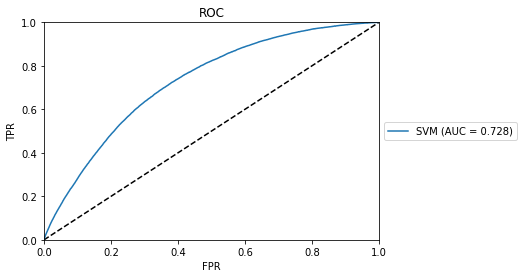


Confusion Matrix:
                 predicted negative  predicted positive
actual negative              133499               91556
actual positive               56956              168099


In [106]:
get_results(train_y_ros_arr, train_pred, train_score)

### out-of-sample validation score

In [107]:
grid_sgd.score(BoW_val_X_extra, val_y_arr)

0.717569861815602

In [0]:
# evalute the best model on the actual validation set
val_pred = grid_sgd.predict(BoW_val_X_extra)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
val_score = grid_sgd.decision_function(BoW_val_X_extra)
# this returns a ndarray of shape (n_samples, )

au_roc score: 0.717569861815602
average precision score: 0.20462315475919085


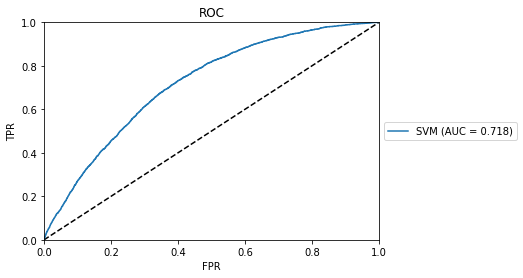


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               19047               13223
actual positive                 951                2697


In [109]:
get_results(val_y_arr, val_pred, val_score)

## linear SVM with BoW_extra data - no early stopping

In [90]:
# create SGDclassifier object
sgd = SGDClassifier()

# create a dict where keys are param names and values are a list of values to try for that param
grid_values = {'loss':['hinge', 'log'], 
               'penalty':['l2', 'l1', 'elasticnet'],
               'alpha':[10**(-i) for i in range(6)],
               'tol':[10**(-i) for i in range(2,5)],
               'early_stopping':[False]
               }

# create gridSearch object specifying model, params to search over, the scoring metric
grid_sgd = GridSearchCV(sgd, param_grid = grid_values, scoring = 'roc_auc')

# fit on data
start = time.time()
grid_sgd.fit(BoW_train_X_extra, train_y_ros_arr)
print(time.time()-start)

# time: 4741

4741.603350400925


In [91]:
grid_sgd.best_params_

{'alpha': 1e-05,
 'early_stopping': False,
 'loss': 'hinge',
 'penalty': 'l2',
 'tol': 0.0001}

### in-sample score

In [92]:
# Mean cross-validated score of the best_estimator
grid_sgd.best_score_

0.71652904698443

In [95]:
# this is the same as the following
# which proves that grid score does use y_score to calculate and return auROC score
# and that it does use this correct auROC score to select the best model
print('this is the trianing AUC! not the validation:',grid_sgd.score(BoW_train_X_extra, train_y_ros_arr))

this is the trianing AUC! not the validation 0.8591245083568697


In [0]:
# evalute the best model on the actual validation set
train_pred = grid_sgd.predict(BoW_train_X_extra)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
train_score = grid_sgd.decision_function(BoW_train_X_extra)
# this returns a ndarray of shape (n_samples, )

au_roc score: 0.8591245083568697
average precision score: 0.8093522448265416


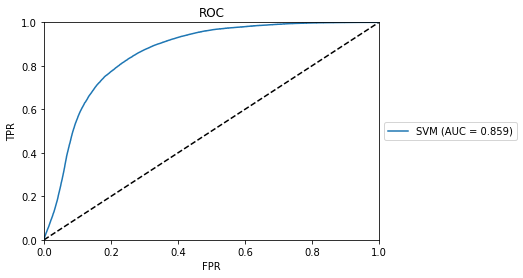


Confusion Matrix:
                 predicted negative  predicted positive
actual negative              146687               78368
actual positive               21533              203522


In [97]:
get_results(train_y_ros_arr, train_pred, train_score)

### out-of-sample validation score

In [98]:
grid_sgd.score(BoW_val_X_extra, val_y_arr)

0.6934386450807062

In [0]:
# evalute the best model on the actual validation set
val_pred = grid_sgd.predict(BoW_val_X_extra)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
val_score = grid_sgd.decision_function(BoW_val_X_extra)
# this returns a ndarray of shape (n_samples, )

au_roc score: 0.6934386450807062
average precision score: 0.18094190895232182


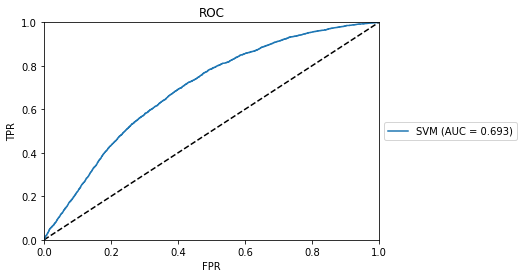


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               18834               13436
actual positive                1068                2580


In [100]:
get_results(val_y_arr, val_pred, val_score)

Even after grid search, our `auc` is still very bad, as bad as the Naive Bayes baseline. This suggests that our data is not linearly separable in its current dimension of 73937 dimension-space. So linear SVM performs poorly.

## linear SVM with tfidf_extra data - early stopping

In [181]:
# create SGDclassifier object
sgd = SGDClassifier()

# create a dict where keys are param names and values are a list of values to try for that param
grid_values = {'loss':['hinge', 'log'], 
               'penalty':['l2', 'l1', 'elasticnet'],
               'alpha':[10**(-i) for i in range(6)],
               'tol':[10**(-i) for i in range(2,5)],
               'early_stopping':[True]
               }

# create gridSearch object specifying model, params to search over, the scoring metric
grid_sgd = GridSearchCV(sgd, param_grid = grid_values, scoring = 'roc_auc')

# fit on data
start = time.time()
grid_sgd.fit(tfidf_train_X_extra, train_y_ros_arr)
print(time.time()-start)


1295.5717129707336


In [182]:
grid_sgd.best_params_

{'alpha': 1e-05,
 'early_stopping': True,
 'loss': 'hinge',
 'penalty': 'l2',
 'tol': 0.01}

In [183]:
# Mean cross-validated score of the best_estimator
grid_sgd.best_score_

0.6998614621082844

In [0]:
# evalute the best model on the actual validation set
val_pred = grid_sgd.predict(tfidf_val_X_extra)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
val_score = grid_sgd.decision_function(tfidf_val_X_extra)
# this returns a ndarray of shape (n_samples, )

In [185]:
grid_sgd.score(tfidf_val_X_extra, val_y_arr)

0.7208321101017185

au_roc score: 0.7208321101017185
average precision score: 0.2104445473795132


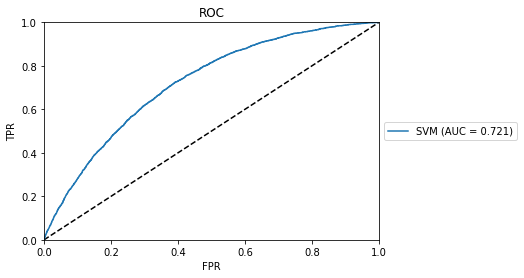


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               20758               11512
actual positive                1144                2504


In [186]:
get_results(val_y_arr, val_pred, val_score)

## linear SVM with tfidf_extra data - no early stopping

In [0]:
# create SGDclassifier object
sgd = SGDClassifier()

# create a dict where keys are param names and values are a list of values to try for that param
grid_values = {'loss':['hinge', 'log'], 
               'penalty':['l2', 'l1', 'elasticnet'],
               'alpha':[10**(-i) for i in range(6)],
               'tol':[10**(-i) for i in range(2,5)],
               'early_stopping':[False]
               }

# create gridSearch object specifying model, params to search over, the scoring metric
grid_sgd = GridSearchCV(sgd, param_grid = grid_values, scoring = 'roc_auc')

# fit on data
start = time.time()
grid_sgd.fit(tfidf_train_X_extra, train_y_ros_arr)
print(time.time()-start)

In [84]:
grid_sgd.best_params_

{'alpha': 1e-05,
 'early_stopping': False,
 'loss': 'hinge',
 'penalty': 'l2',
 'tol': 0.0001}

In [85]:
# Mean cross-validated score of the best_estimator
grid_sgd.best_score_

0.7022842707632334

In [0]:
# evalute the best model on the actual validation set
val_pred = grid_sgd.predict(tfidf_val_X_extra)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
val_score = grid_sgd.decision_function(tfidf_val_X_extra)
# this returns a ndarray of shape (n_samples, )

In [87]:
grid_sgd.score(tfidf_val_X_extra, val_y_arr)

0.7212520777948125

au_roc score: 0.7212520777948125
average precision score: 0.21040369066123873


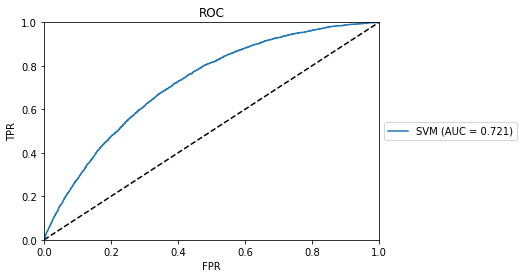


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               20992               11278
actual positive                1180                2468


In [89]:
get_results(val_y_arr, val_pred, val_score)

## poly SVM with tfidf_extra data - early stopping

In [60]:
best_params2

{'auc': 0.7176280290272862,
 'coef0': 1,
 'degree': 2,
 'gamma': 1,
 'kernel': 'poly',
 'n_components': 600}

`best_param2 = {'auc': 0.7176280290272862,
 'coef0': 1,
 'degree': 2,
 'gamma': 1,
 'kernel': 'poly',
 'n_components': 600}`

In [0]:
# initialize kernel object for use 
poly_kernel = Nystroem(kernel='poly',
                       coef0=1,
                       gamma=1,
                       degree = 2,
                       random_state=1,
                       n_components=600)

In [64]:
# kernel transform our input data, so for both train and validation
start = time.time()
tfidf_train_X_extra_poly = poly_kernel.fit_transform(tfidf_train_X_extra)
tfidf_val_X_extra_poly = poly_kernel.transform(tfidf_val_X_extra)
print(time.time()-start)

33.023457527160645


In [65]:
tfidf_train_X_extra_poly.shape

(450110, 600)

In [66]:
# create SGDclassifier object
sgd = SGDClassifier()

# create a dict where keys are param names and values are a list of values to try for that param
grid_values = {'loss':['hinge', 'log'], 
               'penalty':['l2', 'l1', 'elasticnet'],
               'alpha':[10**(-i) for i in range(6)],
               'tol':[10**(-i) for i in range(2,5)],
               'early_stopping':[True]
               }

# create gridSearch object specifying model, params to search over, the scoring metric
grid_sgd = GridSearchCV(sgd, param_grid = grid_values, scoring = 'roc_auc')

start = time.time()
# fit on data
grid_sgd.fit(tfidf_train_X_extra_poly, train_y_ros_arr)

print('time:',time.time()-start)

# time: 7827

time: 7826.69792842865


In [67]:
grid_sgd.best_params_

{'alpha': 0.001,
 'early_stopping': True,
 'loss': 'hinge',
 'penalty': 'l2',
 'tol': 0.01}

### in-sample score

In [96]:
# Mean cross-validated score of the best_estimator
grid_sgd.best_score_

0.7009612785273793

In [98]:
# this is the same as the following
# which proves that grid score does use y_score to calculate and return auROC score
# and that it does use this correct auROC score to select the best model
print('this is the training AUC! not the validation:',grid_sgd.score(tfidf_train_X_extra_poly, train_y_ros_arr))

this is the training AUC! not the validation: 0.7200914329927277


au_roc score: 0.7200914329927277
average precision score: 0.6954322016579289


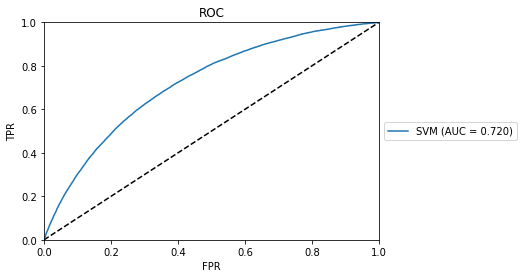


Confusion Matrix:
                 predicted negative  predicted positive
actual negative              139873               85182
actual positive               66666              158389


In [99]:
# evalute the best model on the actual validation set
train_pred = grid_sgd.predict(tfidf_train_X_extra_poly)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
train_score = grid_sgd.decision_function(tfidf_train_X_extra_poly)
# this returns a ndarray of shape (n_samples, )

get_results(train_y_ros_arr, train_pred, train_score)

In [100]:
train_score.min()

-6.655746523095762

In [101]:
train_score.max()

3.1000317526562124

From this, we can see that the most confident negative classes (real reviews) gets a score of about -6, and the most confident positive classes (fake reviews) gets a score of about 3.

### out-of-sample validation score

In [93]:
grid_sgd.score(tfidf_val_X_extra_poly, val_y_arr)

0.7128204059837772

In [0]:
# evalute the best model on the actual validation set
val_pred = grid_sgd.predict(tfidf_val_X_extra_poly)
# this returns a ndarray of shape (n_samples, )

val_score = grid_sgd.decision_function(tfidf_val_X_extra_poly)

au_roc score: 0.7128204059837772
average precision score: 0.20649173448703173


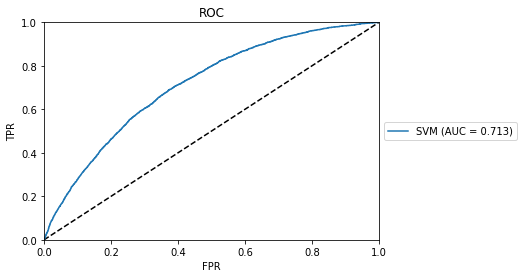


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               16503               15767
actual positive                 770                2878


In [71]:
get_results(val_y_arr, val_pred, val_score)

In [94]:
val_score.min()

-6.731194620429169

In [95]:
val_score.max()

3.0629565067229017

Based on this, we see that the `decision_score` ranges varies and is not a probability.

# Best model re-fit

In [0]:
# create SGDclassifier object using the best model
sgd = SGDClassifier(random_state=1,
                    alpha = 1e-05,
                    early_stopping = True,
                    loss = 'hinge',
                    penalty = 'l2',
                    tol = 0.01)

In [50]:
# fit the model to our training data
sgd.fit(tfidf_train_X_extra, train_y_ros_arr)

SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.01,
              validation_fraction=0.1, verbose=0, warm_start=False)

### in-sample score

au_roc score: 0.8023525107307272
average precision score: 0.7677805388621346


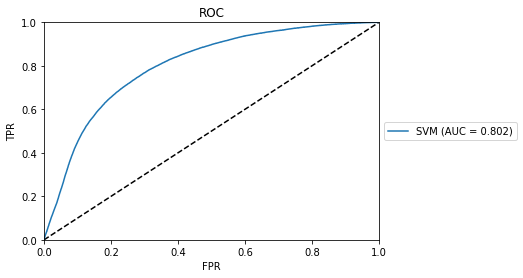


Confusion Matrix:
                 predicted negative  predicted positive
actual negative              152825               72230
actual positive               47910              177145


In [54]:
# evalute the best model on the actual validation set
train_pred = sgd.predict(tfidf_train_X_extra)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
train_score = sgd.decision_function(tfidf_train_X_extra)
# this returns a ndarray of shape (n_samples, )

get_results(train_y_ros_arr, train_pred, train_score)

In [55]:
train_score.min()

-4.909897584901556

In [56]:
train_score.max()

3.8197461965827713

From this, we can see that the most confident negative classes (real reviews) gets a score of about -5, and the most confident positive classes (fake reviews) gets a score of about 3.

## out-of-sample validation score

In [0]:
# predict the labels for our validation set
val_pred = sgd.predict(tfidf_val_X_extra)
# this returns a ndarray of shape (n_samples, )

# predict the confidence score for our validation set
val_score = sgd.decision_function(tfidf_val_X_extra)
# this returns a ndarray of shape (n_samples, )

au_roc score: 0.7199134631589821
average precision score: 0.20832265867692162


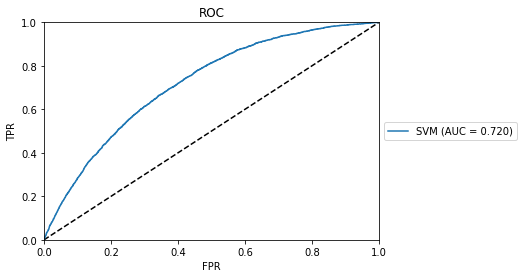


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               21156               11114
actual positive                1222                2426


In [57]:
get_results(val_y_arr, val_pred, val_score)

## reinforced validation score

In [0]:
# reinforce the decision function score using dummy classifier
val_score[fake_rows] = 4
val_score[good_rows] = -6

au_roc score: 0.9122019434771855
average precision score: 0.6085882870103728


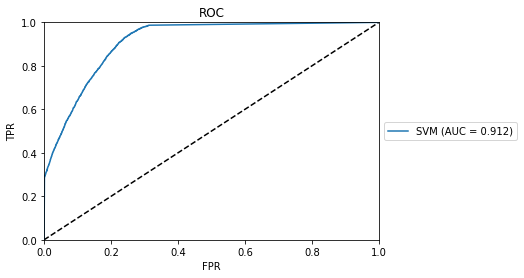


Confusion Matrix:
                 predicted negative  predicted positive
actual negative               21156               11114
actual positive                1222                2426


In [68]:
get_results(val_y_arr, val_pred, val_score)